# Imapp benchmarking data - full compute opcodes analysis

#### Maria Silva, September 2025

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [3]:
# plotting theme
sns.set_theme(
    style="whitegrid", palette="Set2", rc={"figure.dpi": 500, "axes.titlesize": 15}
)

## Load and proces data

In this analysis, we are using data generated by the [`gas-cost-estimator` tool from Imapp](https://github.com/imapp-pl/gas-cost-estimator). The data we use can be downloaded in their repository [here](https://github.com/imapp-pl/gas-cost-estimator/tree/master/src/stage5).

In [4]:
# Main directories
current_path = os.getcwd()
repo_dir = os.path.abspath(os.path.join(current_path, ".."))
data_dir = os.path.join(repo_dir, "data", "imapp_benchmarks")
results_dir = os.path.join(data_dir, "results")

#### Load execution times data

In [5]:
# List csv files in results_dir
files = [f for f in os.listdir(results_dir) if f.endswith(".csv")]
# Load all csv files into a single dataframe
df_list = []
for f in files:
    f_df = pd.read_csv(os.path.join(results_dir, f))
    f_df["bench_client"] = f.split("_")[-1][:-4]
    f_df["bench_type"] = "_".join(f.split("_")[1:-1])
    df_list.append(f_df)
raw_df = pd.concat(df_list, ignore_index=True)
# Filter clients and bench types
raw_df = raw_df[~raw_df["bench_client"].isin(["evmone", "ethereumjs"])]
raw_df = raw_df[
    ~raw_df["bench_type"].isin(["arguments_v3", "arguments_full_c200_opc15"])
]
# Print info
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 286134 entries, 315 to 358910
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   program_id        286134 non-null  object 
 1   sample_id         286134 non-null  int64  
 2   total_time_ns     286134 non-null  float64
 3   mem_allocs        141893 non-null  float64
 4   mem_alloc_bytes   141893 non-null  float64
 5   bench_client      286134 non-null  object 
 6   bench_type        286134 non-null  object 
 7   iterations_count  188472 non-null  float64
 8   std_dev_time_ns   188472 non-null  float64
 9   gasUsed           84772 non-null   object 
 10  pass              84772 non-null   object 
dtypes: float64(5), int64(1), object(5)
memory usage: 26.2+ MB


In [6]:
raw_df[raw_df["std_dev_time_ns"].isna()]["bench_client"].unique()

array(['erigon', 'geth'], dtype=object)

In [7]:
raw_df[~raw_df["std_dev_time_ns"].isna()]["bench_client"].unique()

array(['nethermind', 'revm', 'besu'], dtype=object)

#### Load benchmark info

In [8]:
# List csv files in data_dir
files = [f for f in os.listdir(data_dir) if f.endswith(".csv")]
# Load all csv files into a single dataframe
df_list = []
for f in files:
    f_df = pd.read_csv(os.path.join(data_dir, f)).drop(columns=["bytecode"])
    f_df["bench_type"] = f[3:-4]
    df_list.append(f_df)
prog_df = pd.concat(df_list, ignore_index=True)
prog_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169038 entries, 0 to 169037
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   program_id  169038 non-null  object 
 1   opcode      169038 non-null  object 
 2   op_count    169038 non-null  int64  
 3   bench_type  169038 non-null  object 
 4   arg0        122589 non-null  float64
 5   arg1        100389 non-null  float64
 6   arg2        22200 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 9.0+ MB


In [9]:
prog_df.sort_values("program_id")

,program_id,opcode,op_count,bench_type,arg0,arg1,arg2
88,ADDMOD_0,ADDMOD,0,marginal_full_step5,NaN,NaN,NaN
167608,ADDMOD_0,ADDMOD,0,marginal_full_step5_v2,NaN,NaN,NaN
90,ADDMOD_10,ADDMOD,10,marginal_full_step5,NaN,NaN,NaN
167610,ADDMOD_10,ADDMOD,10,marginal_full_step5_v2,NaN,NaN,NaN
167611,ADDMOD_15,ADDMOD,15,marginal_full_step5_v2,NaN,NaN,NaN
...,...,...,...,...,...,...,...
167749,XOR_45,XOR,45,marginal_full_step5_v2,NaN,NaN,NaN
221,XOR_5,XOR,5,marginal_full_step5,NaN,NaN,NaN
167741,XOR_5,XOR,5,marginal_full_step5_v2,NaN,NaN,NaN
167750,XOR_50,XOR,50,marginal_full_step5_v2,NaN,NaN,NaN


#### Join datasets

In [10]:
df = raw_df.merge(prog_df, on=["program_id", "bench_type"], how="left")
df["op_count"] = np.where(
    df["op_count"].isna(), df["program_id"].str.split("_").str[-1], df["op_count"]
).astype(int)
df["opcode"] = np.where(
    df["opcode"].isna(), df["program_id"].str.split("_").str[0], df["opcode"]
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286134 entries, 0 to 286133
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   program_id        286134 non-null  object 
 1   sample_id         286134 non-null  int64  
 2   total_time_ns     286134 non-null  float64
 3   mem_allocs        141893 non-null  float64
 4   mem_alloc_bytes   141893 non-null  float64
 5   bench_client      286134 non-null  object 
 6   bench_type        286134 non-null  object 
 7   iterations_count  188472 non-null  float64
 8   std_dev_time_ns   188472 non-null  float64
 9   gasUsed           84772 non-null   object 
 10  pass              84772 non-null   object 
 11  opcode            286134 non-null  object 
 12  op_count          286134 non-null  int64  
 13  arg0              189024 non-null  float64
 14  arg1              176409 non-null  float64
 15  arg2              41400 non-null   float64
dtypes: float64(8), int64

## Fixed costs estimation

In [11]:
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm

In [12]:
op = "ADD"
client="geth"
op_df = df[(df["bench_client"]==client) & (df["opcode"] == op)]

X = op_df["op_count"].values.reshape(-1, 1)
y = op_df["total_time_ns"].values
model = LinearRegression()
model.fit(X, y)
intercept = model.intercept_
slope = model.coef_[0]
print(f"Opcode: {op}, Intercept: {intercept:.2f}, Slope: {slope:.2f}")

Opcode: ADD, Intercept: 7481.23, Slope: -17.76


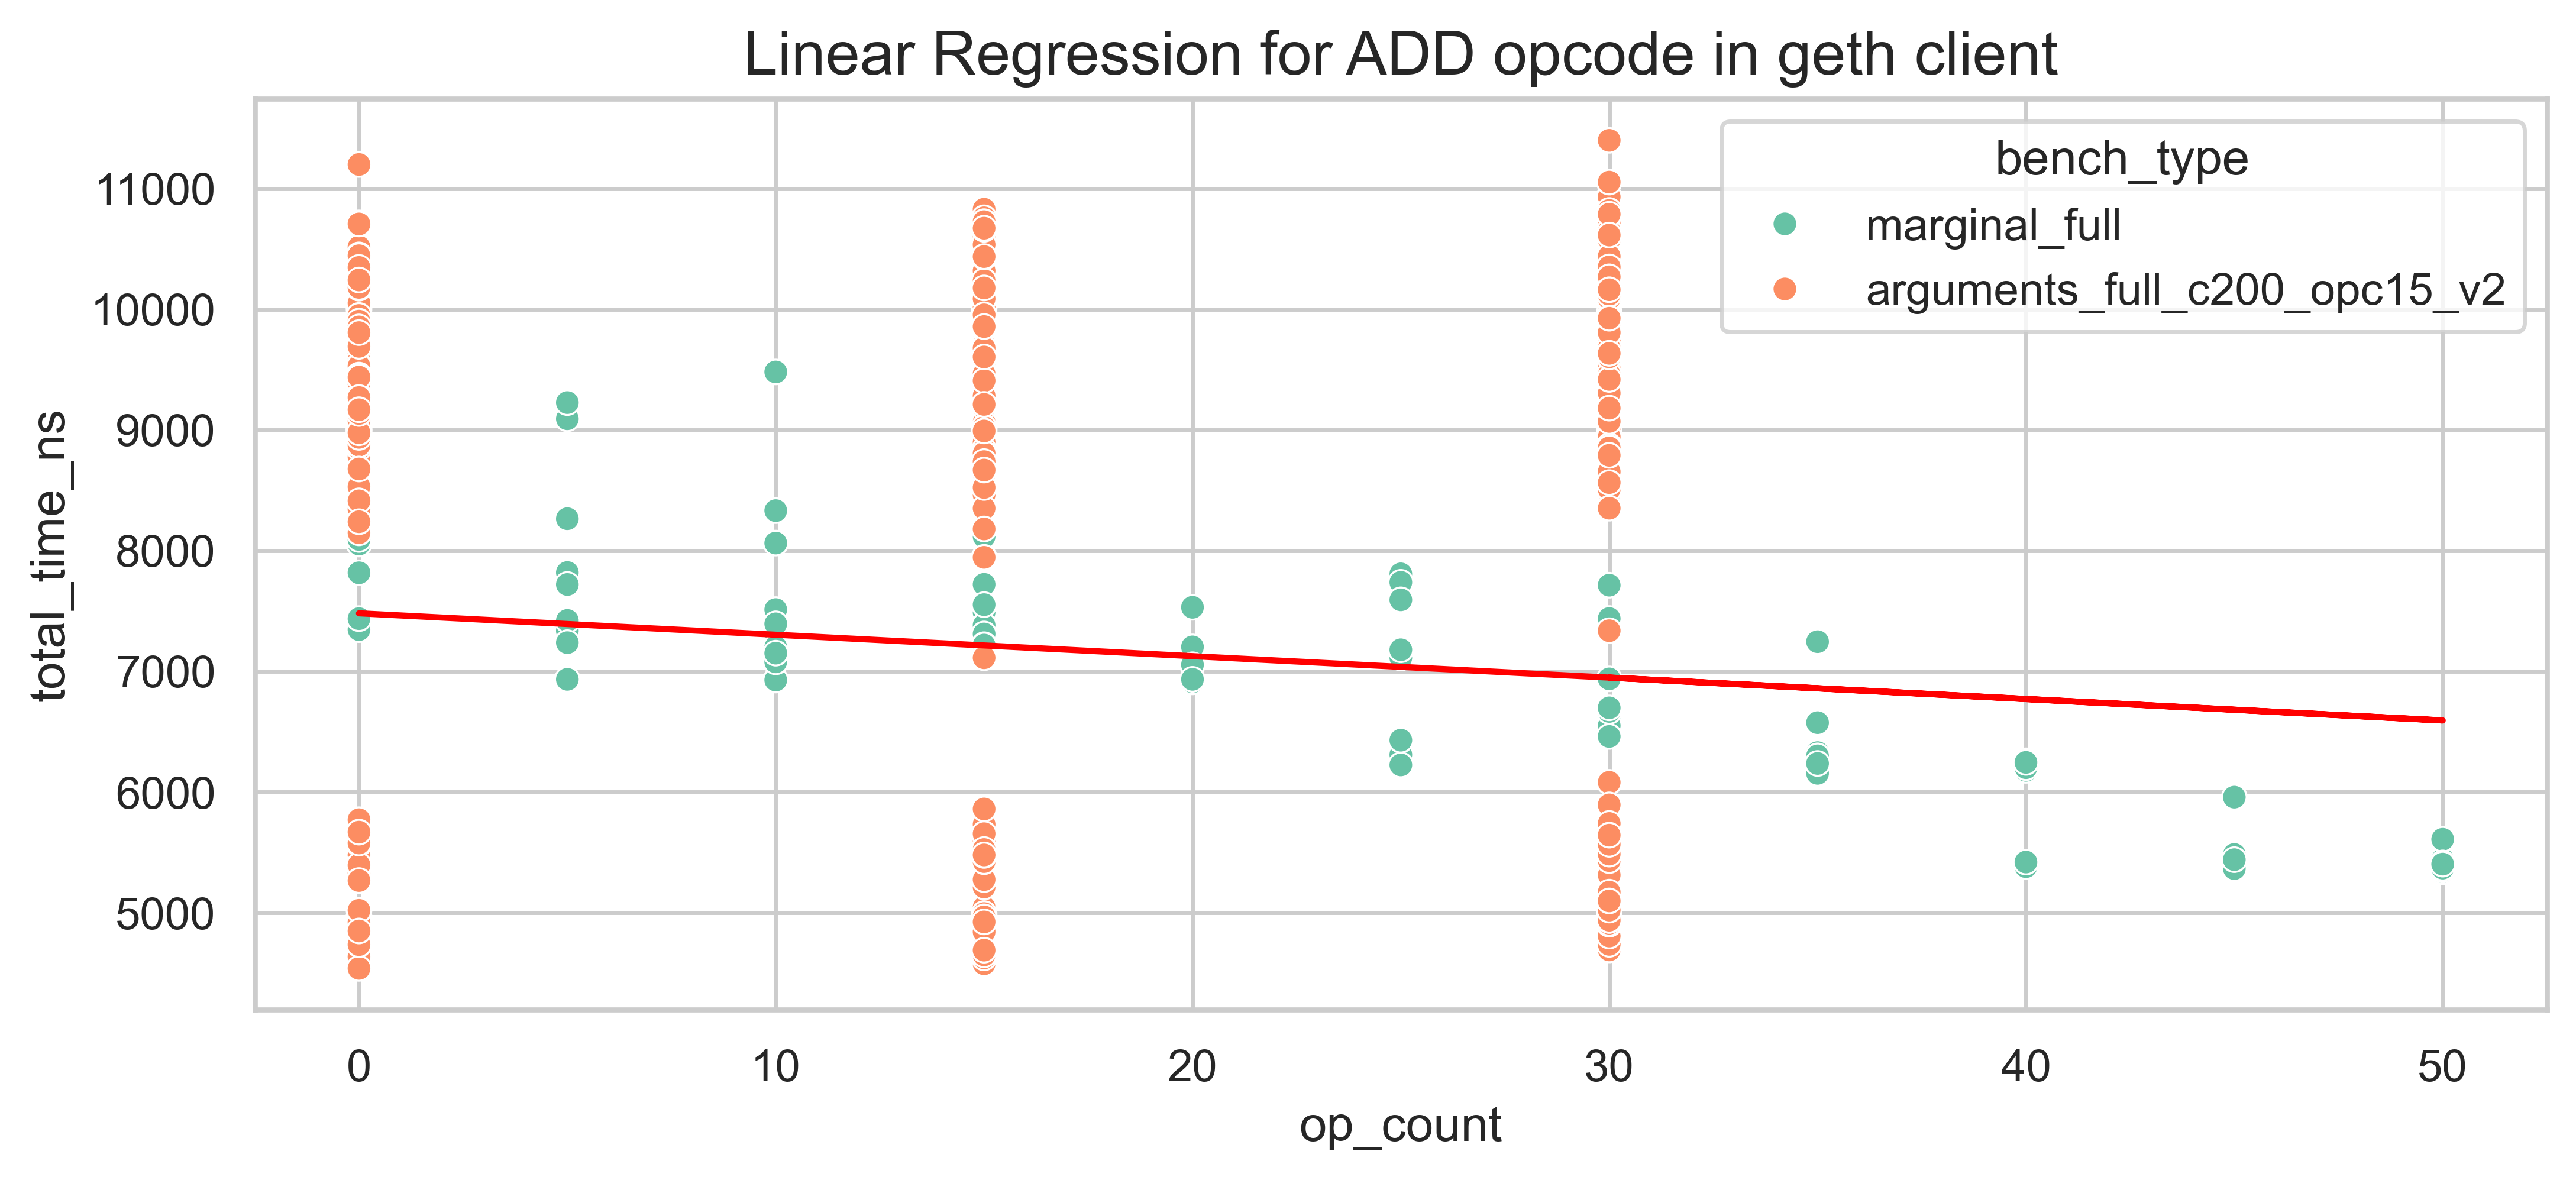

In [13]:
plt.figure(figsize=(10, 4))
sns.scatterplot(
    data=op_df,
    x="op_count",
    y="total_time_ns",
    hue="bench_type"
)
plt.plot(X, model.predict(X), color="red", label="Regression line")
plt.title(f"Linear Regression for {op} opcode in {client} client")
plt.show()

In [14]:
# plot regression results

In [15]:
op = "ADD"
op_df = fixed_df[fixed_df["opcode"] == op]

X_df = pd.DataFrame(X, columns=feature_names)
X_with_intercept_df = sm.add_constant(X_df)  # adds intercept
logit_model = sm.Logit(y, X_with_intercept_df)
result = logit_model.fit()
result.summary()

NameError: name 'fixed_df' is not defined

In [ ]:
for op in fixed_df["opcode"].unique():
    op_df = fixed_df[fixed_df["opcode"] == op]
    X = op_df["op_count"].values.reshape(-1, 1)
    y = op_df["total_time_ns"].values
    model = LinearRegression()
    model.fit(X, y)
    intercept = model.intercept_
    slope = model.coef_[0]
    print(f"Opcode: {op}, Intercept: {intercept:.2f}, Slope: {slope:.2f}")